In [610]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Decision Tree

In [611]:
class node:
  def __init__(self, attribute: str = None, leaf: bool = False, value: str = None):
    self.attribute = attribute
    self.edges = {}
    self.leaf = leaf
    self.value = value

  def find_leaf(self, row: dict):
    if self.value:
      return self.value
    elif self.leaf:
      return self.edges[row[self.attribute]]
    else:
      return self.edges[row[self.attribute]].find_leaf(row)
    
  def add_edge(self, attribute_value: str, node):
    self.edges[attribute_value] = node
    return self.edges[attribute_value]

  def find_node(self, attribute_value: str):
    return self.edges[attribute_value]

  def set_attribute(self, attribute: str):
    self.attribute = attribute

  def set_value(self, value: str):
    self.value = value

In [612]:
class decision_tree:
  def __init__(self, dataset: pd.DataFrame, target_col: str):
    self.dataset = dataset
    self.target_col = target_col
    self.columns = dataset.columns.drop(target_col)
    self.tree = None
  
  def entropy(self, df: pd.DataFrame) -> float:
    """
    Calculate the entropy of a given attribute.

    @param df: Dataset containing only the attribute class for which we will calculate the entropy.
    """

    entropy = 0

    for target_class in df[self.target_col].unique():
      # Calculate the probability of each class
      prob = df[self.target_col].value_counts()[target_class] / len(df)

      # Calculate the entropy
      entropy -= prob * np.log2(prob)

    return entropy
  
  def information_gain(self, df: pd.DataFrame, attribute: str) -> float:
    """
    Calculate the information gain of a given attribute.

    @param df: Dataset containing only the attribute for which we will calculate the information gain.
    @param attribute: The attribute to calculate the information gain for.
    """

    # Calculate the entropy of the dataset
    entropy_dataset = 0

    for target_class in df[self.target_col].unique():
      # Calculate the probability of each class
      prob = df[df[self.target_col] == target_class][self.target_col].count() / len(df)

      # Calculate the entropy
      entropy_dataset -= prob * np.log2(prob)

    # Calculate the entropy of the attribute
    entropy_attribute = 0

    for attribute_value in df[attribute].unique():
      # Calculate the probability of each attribute value
      prob = df[attribute].value_counts()[attribute_value] / len(df)

      # Calculate the entropy of the attribute
      entropy_attribute -= prob * self.entropy(df[df[attribute] == attribute_value]) 

    return entropy_dataset + entropy_attribute

  def most_informative(self, df: pd.DataFrame) -> str:
    """
    Return the most informative attribute in a given dataset.

    @param df: Dataset containing the attributes for which we will calculate the information gain.
    """

    columns = df.columns.drop(self.target_col)
    information_gains = {}

    for attribute in columns:
      information_gains[attribute] = self.information_gain(df, attribute)

    return max(information_gains, key=information_gains.get)
  
  def is_pure(self, df: pd.DataFrame):
    """
    Check if a given attribute is pure.

    @param attribute: The attribute to check.
    """
    return len(df[self.target_col].unique()) == 1
  
  def build_tree(self, df: pd.DataFrame, current_node: node):
    """
    Build the decision tree. This is a recursive function.

    @param df: The dataset to build the tree on. On every iteration, the dataset will be reduced using the most informative attribute.
    @param current_node: The current node in the tree. On every iteration, a new node will be added to the tree. If no node is given, a new tree will be created.
    """
    # Check if there are no more attributes to split on
    if len(df.columns) == 1:
      return
    
    # Get the most informative attribute
    most_informative = self.most_informative(df)

    if not current_node:
      # Create a new node
      self.tree = node(attribute=most_informative)
      current_node = self.tree
    else:
      current_node.set_attribute(most_informative)

    for edge in df[most_informative].unique():
      # Check if the attribute is pure
      if self.is_pure(df[df[most_informative] == edge]):
        # Add a leaf node
        current_node.add_edge(edge, node(leaf=True, value=df[df[most_informative] == edge][self.target_col].iloc[0]))
      else:
        new_node = current_node.add_edge(edge, node())
        new_df = df[df[most_informative] == edge].drop(most_informative, axis=1)
        if len(new_df.columns) == 1:
          new_node.set_value(new_df[self.target_col].iloc[0])
        else:
          self.build_tree(new_df, new_node)


  def fit(self):
    """
    Fit the decision tree to the dataset.
    """

    df = self.dataset.copy()

    self.build_tree(df, current_node=None)

  def predict(self, df: pd.DataFrame):
    """
    Predict the target class of a given dataset.

    @param df: The dataset to predict the target class for.
    """
    dataset = df.to_dict('records')

    result = []

    for row in dataset:
      result.append(self.tree.find_leaf(row))

    return result

### Exploratory Data Analysis

In [613]:
# Importing dataset
df = pd.read_csv('dataset/cars_india.csv')

<AxesSubplot: >

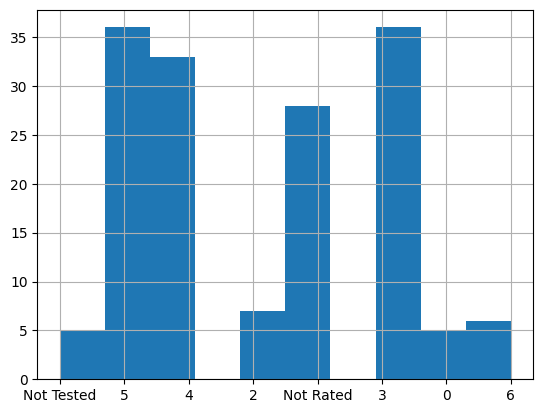

In [614]:
df["NCAP Rating"].hist()

In [615]:
df.head()

,Model,Maker,Type,Seats,Displacement,Length,Width,Height,Wheelbase,No_of_Cylinders,...,Rear Brake,Drive,Turning Radius,Fuel Tank Capacity,Boot Space,Fuel Efficiency,Emission Type,Tyre Size,Variants,NCAP Rating
0,Virtus,Volkswagen,Sedan,5,999.0,4561,1752,1507,2651,3.0,...,Drum,2WD,5.05,45.0,521.0,19.40,BS VI,205/55 R16,3,Not Tested
1,Virtus,Volkswagen,Sedan,5,999.0,4561,1752,1507,2651,3.0,...,Drum,2WD,5.05,45.0,521.0,18.12,BS VI,205/55 R16,2,Not Tested
2,Virtus,Volkswagen,Sedan,5,1498.0,4561,1752,1507,2651,4.0,...,Drum,2WD,5.05,45.0,521.0,18.67,BS VI,205/55 R16,1,Not Tested
3,Taigun,Volkswagen,Mid Size SUV,5,999.0,4221,1760,1612,2651,3.0,...,Drum,2WD,5.05,50.0,385.0,19.20,BS VI,205/55 R17,3,5
4,Taigun,Volkswagen,Mid Size SUV,5,999.0,4221,1760,1612,2651,3.0,...,Drum,2WD,5.05,50.0,385.0,17.23,BS VI,205/55 R17,2,5


In [616]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Model               156 non-null    object 
 1   Maker               156 non-null    object 
 2   Type                156 non-null    object 
 3   Seats               156 non-null    int64  
 4   Displacement        155 non-null    float64
 5   Length              156 non-null    int64  
 6   Width               156 non-null    int64  
 7   Height              156 non-null    int64  
 8   Wheelbase           156 non-null    int64  
 9   No_of_Cylinders     155 non-null    float64
 10  Fuel                156 non-null    object 
 11  Engine Type         156 non-null    object 
 12  Transmission        155 non-null    object 
 13  Front Brake         156 non-null    object 
 14  Rear Brake          156 non-null    object 
 15  Drive               156 non-null    object 
 16  Turning 

In [617]:
df.describe()

,Seats,Displacement,Length,Width,Height,Wheelbase,No_of_Cylinders,Turning Radius,Fuel Tank Capacity,Boot Space,Fuel Efficiency,Variants
count,156.000000,155.000000,156.000000,156.000000,156.000000,156.000000,155.000000,137.000000,155.000000,141.000000,133.000000,156.000000
mean,5.538462,1598.109677,4324.455128,1800.512821,1653.666667,2633.358974,3.870968,5.247080,48.725806,377.673759,18.028947,2.871795
std,1.018440,504.656969,325.767389,79.050452,125.170559,128.228372,0.389966,0.284181,10.997815,105.015951,3.273723,2.864055
min,2.000000,799.000000,3731.000000,1579.000000,1370.000000,2422.000000,3.000000,4.700000,28.000000,180.000000,9.000000,1.000000
25%,5.000000,1197.000000,3995.000000,1751.500000,1544.000000,2500.000000,4.000000,5.100000,40.000000,296.000000,16.200000,1.000000
50%,5.000000,1493.000000,4315.000000,1790.000000,1631.000000,2610.000000,4.000000,5.200000,50.000000,392.000000,18.100000,2.000000
75%,6.000000,1999.000000,4598.000000,1855.000000,1755.000000,2750.000000,4.000000,5.300000,57.000000,447.000000,20.250000,3.000000
max,9.000000,3799.000000,5115.000000,2099.000000,1995.000000,3060.000000,6.000000,5.900000,80.000000,625.000000,28.000000,20.000000


In [618]:
df.isnull().sum()

Model                  0
Maker                  0
Type                   0
Seats                  0
Displacement           1
Length                 0
Width                  0
Height                 0
Wheelbase              0
No_of_Cylinders        1
Fuel                   0
Engine Type            0
Transmission           1
Front Brake            0
Rear Brake             0
Drive                  0
Turning Radius        19
Fuel Tank Capacity     1
Boot Space            15
Fuel Efficiency       23
Emission Type          1
Tyre Size              0
Variants               0
NCAP Rating            0
dtype: int64

In [619]:
df['Tyre Size'].value_counts()

235/60 R18        19
215/60 R17        14
205/65 R16        12
195/55 R16        12
255/16 R18        10
195/60 R16         9
215/55 R18         8
175/60 R15         8
195/65 R15         8
175/65 R15         7
215/60 R16         6
265/65 R17         4
265/60 R18         4
255/65 R18         4
205/55 R17         4
205/55 R16         3
155/80 R13         3
215/65 R16         3
185/55 R16         3
235/65 R17         2
245/75 R16         2
185/65 R15         2
185/65 R16         2
235/55 R18         2
235/70 R16         2
285/35/20          1
185/55 R16 87H     1
215/55 R17         1
Name: Tyre Size, dtype: int64

- Model: Removido por explicar quase tudo dos dados
- Displacement: Removido por não necessariamente trazer pistas sobre a potência do motor - "Quando os veículos eram mais simples — antes que a hibridação e a indução forçada se tornassem tão populares — o deslocamento lhe dava uma boa ideia de quanta potência um motor fazia em relação a outro. Um aumento no tamanho trouxe um aumento aproximadamente proporcional na produção, mas esse não é necessariamente o caso hoje.
Nos carros modernos, a deslocamento do motor é menos uma pista para a saída de um trem de força." [What Is Engine Displacement and Does It Matter?](https://www.capitalone.com/cars/learn/finding-the-right-car/what-is-engine-displacement-and-does-it-matter/2055)
- No_of_Cylinders, Fuel, Fuel Tank Capacity, Fuel Efficiency, Emission Type, Variants: Removido por não ter necessariamente uma relação com a classificação

In [620]:
cars_df = df[['Maker', 'Seats', 'Type', 'Length', 'Width', 'Height', 'Wheelbase', 'Transmission', 'Front Brake', 'Rear Brake', 'Drive', 'Tyre Size', 'NCAP Rating']]
cars_df.shape

(156, 13)

In [621]:
cars_df.isnull().sum()

Maker           0
Seats           0
Type            0
Length          0
Width           0
Height          0
Wheelbase       0
Transmission    1
Front Brake     0
Rear Brake      0
Drive           0
Tyre Size       0
NCAP Rating     0
dtype: int64

In [622]:
# Removing spaces from the Drive column causing difeerent values for same category
cars_df['Drive'] = cars_df['Drive'].str.replace(" ","")
cars_df['Drive'].unique()

/var/folders/k0/sr088lv560v19y4dz_tfgq980000gn/T/ipykernel_47467/3772874607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_df['Drive'] = cars_df['Drive'].str.replace(" ","")


array(['2WD', '4WD', 'AWD'], dtype=object)

In [623]:
cars_df['Transmission'].value_counts()

6 MT                   45
6 AT                   30
5 MT                   25
7 DCT                   9
8 AT                    6
AMT                     6
CVT                     6
IVT                     4
iMT                     3
6-Speed MT              3
6-Speed AT              2
6 TC Automatic          2
6 MT with iMT           2
7-Speed DSG             2
6  iMT                  2
6-Speed DCT             1
7-Speed CVT             1
4 AT                    1
MT                      1
Single                  1
7-Speed DSG 4MOTION     1
DCT                     1
6 iMT                   1
Name: Transmission, dtype: int64

In [624]:
cars_df.shape

(156, 13)

In [625]:
# Removing rows with Transmission values that occur only once
values = cars_df['Transmission'].value_counts() == 1
values = values[values == True]
values_list = [x not in values for x in cars_df['Transmission']]
cars_df = cars_df[values_list]
cars_df.shape

(148, 13)

In [626]:
# Removing rows with Tyre Size values that occur only once
values = cars_df['Tyre Size'].value_counts() == 1
values = values[values == True]
values_list = [x not in values for x in cars_df['Tyre Size']]
cars_df = cars_df[values_list]
cars_df.shape

(145, 13)

#### Split Train/Test

In [627]:
X_train, X_test = train_test_split(cars_df, test_size=0.2, random_state=42, stratify=cars_df['NCAP Rating'])

In [628]:
X_train.shape, X_test.shape

((116, 13), (29, 13))

In [629]:
X_train.isnull().sum()

Maker           0
Seats           0
Type            0
Length          0
Width           0
Height          0
Wheelbase       0
Transmission    0
Front Brake     0
Rear Brake      0
Drive           0
Tyre Size       0
NCAP Rating     0
dtype: int64

In [630]:
X_test.isnull().sum()

Maker           0
Seats           0
Type            0
Length          0
Width           0
Height          0
Wheelbase       0
Transmission    0
Front Brake     0
Rear Brake      0
Drive           0
Tyre Size       0
NCAP Rating     0
dtype: int64

In [631]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 155
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Maker         145 non-null    object
 1   Seats         145 non-null    int64 
 2   Type          145 non-null    object
 3   Length        145 non-null    int64 
 4   Width         145 non-null    int64 
 5   Height        145 non-null    int64 
 6   Wheelbase     145 non-null    int64 
 7   Transmission  145 non-null    object
 8   Front Brake   145 non-null    object
 9   Rear Brake    145 non-null    object
 10  Drive         145 non-null    object
 11  Tyre Size     145 non-null    object
 12  NCAP Rating   145 non-null    object
dtypes: int64(5), object(8)
memory usage: 15.9+ KB


#### Numerical data into categorical data

In [632]:
for col in X_train.columns:
  if X_train[col].dtype == 'int64' or X_train[col].dtype == 'float64':
    X_train[col], boot_intervals = pd.cut(
      X_train[col], 
      bins=3, 
      retbins=True, 
      include_lowest=True
    )

    X_test[col] = pd.cut(
        X_test[col], 
        bins=pd.IntervalIndex.from_breaks(boot_intervals), 
        include_lowest=True
      )

In [633]:
X_train.head()

,Maker,Seats,Type,Length,Width,Height,Wheelbase,Transmission,Front Brake,Rear Brake,Drive,Tyre Size,NCAP Rating
133,Kia,"(3.994, 5.667]",SUV,"(4192.333, 4653.667]","(1714.333, 1849.667]","(1474.479, 1648.333]","(2421.361, 2634.667]",IVT,Disc,Disc,2WD,215/60 R17,3
87,Hyundai,"(3.994, 5.667]",Hatchback,"(3729.615, 4192.333]","(1578.593, 1714.333]","(1474.479, 1648.333]","(2421.361, 2634.667]",5 MT,Disc,Drum,2WD,175/60 R15,2
102,Hyundai,"(3.994, 5.667]",Compact Sedan,"(3729.615, 4192.333]","(1578.593, 1714.333]","(1474.479, 1648.333]","(2421.361, 2634.667]",5 MT,Disc,Drum,2WD,175/60 R15,Not Rated
110,Hyundai,"(3.994, 5.667]",Compact SUV,"(3729.615, 4192.333]","(1714.333, 1849.667]","(1474.479, 1648.333]","(2421.361, 2634.667]",7 DCT,Disc,Drum,2WD,215/60 R16,4
122,Hyundai,"(5.667, 7.333]",SUV,"(4192.333, 4653.667]","(1714.333, 1849.667]","(1648.333, 1821.667]","(2634.667, 2847.333]",6 MT,Disc,Disc,2WD,215/55 R18,Not Rated


In [634]:
X_test.head()

,Maker,Seats,Type,Length,Width,Height,Wheelbase,Transmission,Front Brake,Rear Brake,Drive,Tyre Size,NCAP Rating
46,Mahindra,"(5.666666666666667, 7.333333333333334]",SUV,"(4653.666666666667, 5115.0]","(1849.6666666666667, 1985.0]","(1821.6666666666667, 1995.0]","(2634.6666666666665, 2847.3333333333335]",6 MT,Disc,Disc,2WD,255/16 R18,Not Rated
60,Mahindra,"(5.666666666666667, 7.333333333333334]",SUV,"(4653.666666666667, 5115.0]","(1849.6666666666667, 1985.0]","(1648.3333333333333, 1821.6666666666667]","(2634.6666666666665, 2847.3333333333335]",6 AT,Disc,Disc,2WD,235/60 R18,5
18,Honda,"(3.995, 5.666666666666667]",Compact SUV,"(3729.616, 4192.333333333333]","(1714.3333333333333, 1849.6666666666667]","(1474.48, 1648.3333333333333]","(2421.362, 2634.6666666666665]",6 MT,Disc,Drum,2WD,195/60 R16,4
76,Toyota,"(5.666666666666667, 7.333333333333334]",SUV,"(4653.666666666667, 5115.0]","(1849.6666666666667, 1985.0]","(1821.6666666666667, 1995.0]","(2634.6666666666665, 2847.3333333333335]",6 MT with iMT,Disc,Disc,4WD,265/60 R18,5
135,Kia,"(3.995, 5.666666666666667]",SUV,"(4192.333333333333, 4653.666666666667]","(1714.3333333333333, 1849.6666666666667]","(1474.48, 1648.3333333333333]","(2421.362, 2634.6666666666665]",7 DCT,Disc,Disc,2WD,215/60 R17,3


#### Using Decision Tree

In [635]:
tree = decision_tree(X_train, 'NCAP Rating')

In [636]:
tree.fit()

In [637]:
y_test = tree.predict(X_test)

In [638]:
accuracy_score(X_test['NCAP Rating'], y_test)

0.9655172413793104